In [2]:
# mounting drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from torch import optim
import random
from copy import deepcopy
import time
import pprint

In [4]:
print(torch.cuda.is_available())

True


In [5]:
# read in classification dataset and store in dataframe
df = pd.read_csv('/content/gdrive/MyDrive/data/classification_data/classification_train.tsv', sep=' ', index_col=0)

In [6]:
df.head(n=10)

,class,sentence
0,chemistry,the approximate analysis of nonlinear behavior...
1,chemistry,flow of particles through slits in the bottom ...
2,chemistry,scanning probe memories technology and applica...
3,chemistry,influence of disodium hydrogen phosphate dodec...
4,chemistry,highly luminescent lead bromide perovskite nan...
5,chemistry,condensation of propiolic esters with olefins ...
6,chemistry,anisotropy of paramagnetic susceptibility of c...
7,chemistry,the use of copper standards with copper fluori...
8,chemistry,nucleation of silicalite precursors during syn...
9,chemistry,analytical procedure for the determination of ...


In [7]:
train_percent = 0.2
validation_percent = 0.05
test_percent = 0.05

df = df.sample(frac=1)
a = int(len(df)*train_percent)
b = int(a + len(df)*validation_percent)
c = int(b + len(df)*test_percent)

train_data = df[0:a]
validation_data = df[a:b]
test_data = df[b:c]

print(train_data.head())
print(validation_data.head())
print(test_data.head())

              class                                           sentence
1405563   sociology  prerogative parliament and creative constituti...
947662   psychology              moral intuition and moral reasoning\n
1463027   sociology  we are illegal here the communist party self d...
216129    chemistry  study of anti skin photoaging by ginsenoside r...
1358186   sociology       for bees many roads lead to social harmony\n
              class                                           sentence
1110847  psychology  involvement of astrocyte activation in locus c...
227036    chemistry  copper ii purine complexes encapsulated in nay...
1021048  psychology                                      no more 不在了\n
699302      polisci   a candidate s guide to the 2016 state election\n
663373      polisci  the future of the euro area the possible refor...
              class                                           sentence
1202741   sociology  review of taking journalism seriously news and...
446847

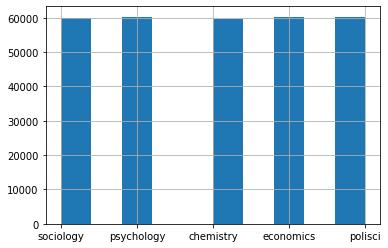

In [8]:
train_data['class'].hist()

In [9]:
class SentenceExample:
    """
    Data wrapper for a single example for sentiment analysis.

    Attributes:
        words (List[string]): list of words
        label (int): 0 or 1 (0 = negative, 1 = positive)
    """

    def __init__(self, words, label):
        self.words = words
        self.label = label

    def __repr__(self):
        return repr(self.words) + "; label=" + repr(self.label)

    def __str__(self):
        return self.__repr__()

In [10]:
CLASS_LABELS = {
    'chemistry': 0,
    'economics': 1,
    'polisci' : 2,
    'psychology' : 3,
    'sociology' : 4
}

In [11]:
train_exs = []
for i, row in train_data.iterrows():
  sentence = row['sentence'].split(' ')
  sentence[-1] = sentence[-1].strip()
  train_exs.append(SentenceExample(sentence, CLASS_LABELS[row['class']]))

In [12]:
validation_exs = []
for i, row in validation_data.iterrows():
  sentence = row['sentence'].split(' ')
  sentence[-1] = sentence[-1].strip()
  validation_exs.append(SentenceExample(sentence, CLASS_LABELS[row['class']]))

In [13]:
test_exs = []
for i, row in test_data.iterrows():
  sentence = row['sentence'].split(' ')
  sentence[-1] = sentence[-1].strip()
  test_exs.append(SentenceExample(sentence, CLASS_LABELS[row['class']]))

In [14]:
class Indexer(object):
    """
    Bijection between objects and integers starting at 0. Useful for mapping
    labels, features, etc. into coordinates of a vector space.

    Attributes:
        objs_to_ints
        ints_to_objs
    """
    def __init__(self):
        self.objs_to_ints = {}
        self.ints_to_objs = {}

    def __repr__(self):
        return str([str(self.get_object(i)) for i in range(0, len(self))])

    def __str__(self):
        return self.__repr__()

    def __len__(self):
        return len(self.objs_to_ints)

    def get_object(self, index):
        """
        :param index: integer index to look up
        :return: Returns the object corresponding to the particular index or None if not found
        """
        if (index not in self.ints_to_objs):
            return None
        else:
            return self.ints_to_objs[index]

    def contains(self, object):
        """
        :param object: object to look up
        :return: Returns True if it is in the Indexer, False otherwise
        """
        return self.index_of(object) != -1

    def index_of(self, object):
        """
        :param object: object to look up
        :return: Returns -1 if the object isn't present, index otherwise
        """
        if (object not in self.objs_to_ints):
            return -1
        else:
            return self.objs_to_ints[object]

    def add_and_get_index(self, object, add=True):
        """
        Adds the object to the index if it isn't present, always returns a nonnegative index
        :param object: object to look up or add
        :param add: True by default, False if we shouldn't add the object. If False, equivalent to index_of.
        :return: The index of the object
        """
        if not add:
            return self.index_of(object)
        if (object not in self.objs_to_ints):
            new_idx = len(self.objs_to_ints)
            self.objs_to_ints[object] = new_idx
            self.ints_to_objs[new_idx] = object
        return self.objs_to_ints[object]

In [15]:
class WordEmbeddings:
    """
    Wraps an Indexer and a list of 1-D numpy arrays where each position in the list is the vector for the corresponding
    word in the indexer. The 0 vector is returned if an unknown word is queried.
    """
    def __init__(self, word_indexer, vectors):
        self.word_indexer = word_indexer
        self.vectors = vectors

    def get_embedding_length(self):
        return len(self.vectors[0])

    def get_embedding(self, word):
        """
        Returns the embedding for a given word
        :param word: The word to look up
        :return: The UNK vector if the word is not in the Indexer or the vector otherwise
        """
        word_idx = self.word_indexer.index_of(word)
        if word_idx != -1:
            return self.vectors[word_idx]
        else:
            return self.vectors[self.word_indexer.index_of("UNK")]

In [16]:
def read_word_embeddings(embeddings_file: str) -> WordEmbeddings:
    """
    Loads the given embeddings (ASCII-formatted) into a WordEmbeddings object. Augments this with an UNK embedding
    that is the 0 vector. Reads in all embeddings with no filtering -- you should only use this for relativized
    word embedding files.
    :param embeddings_file: path to the file containing embeddings
    :return: WordEmbeddings object reflecting the words and their embeddings
    """
    f = open(embeddings_file)
    word_indexer = Indexer()
    vectors = []
    # Make position 0 a PAD token, which can be useful if you
    word_indexer.add_and_get_index("PAD")
    # Make position 1 the UNK token
    word_indexer.add_and_get_index("UNK")
    for i, line in enumerate(f):
        if line.strip() != "":
            space_idx = line.find(' ')
            word = line[:space_idx]
            numbers = line[space_idx+1:]
            float_numbers = [float(number_str) for number_str in numbers.split()]
            vector = np.array(float_numbers)
            word_indexer.add_and_get_index(word)
            # Append the PAD and UNK vectors to start. Have to do this weirdly because we need to read the first line
            # of the file to see what the embedding dim is
            if len(vectors) == 0:
                vectors.append(np.zeros(vector.shape[0]))
                vectors.append(np.zeros(vector.shape[0]))
            vectors.append(vector)
        if i % 10000 == 0:
          print(f'done reading {i} embeddings')
    f.close()
    print("Read in " + repr(len(word_indexer)) + " vectors of size " + repr(vectors[0].shape[0]))
    # Turn vectors into a 2-D numpy array
    return WordEmbeddings(word_indexer, np.array(vectors))

In [17]:
embeddings = read_word_embeddings("/content/gdrive/MyDrive/embeddings/glove/baseline/glove.6B.100d.txt")
print(len(embeddings.word_indexer))

done reading 0 embeddings
done reading 10000 embeddings
done reading 20000 embeddings
done reading 30000 embeddings
done reading 40000 embeddings
done reading 50000 embeddings
done reading 60000 embeddings
done reading 70000 embeddings
done reading 80000 embeddings
done reading 90000 embeddings
done reading 100000 embeddings
done reading 110000 embeddings
done reading 120000 embeddings
done reading 130000 embeddings
done reading 140000 embeddings
done reading 150000 embeddings
done reading 160000 embeddings
done reading 170000 embeddings
done reading 180000 embeddings
done reading 190000 embeddings
done reading 200000 embeddings
done reading 210000 embeddings
done reading 220000 embeddings
done reading 230000 embeddings
done reading 240000 embeddings
done reading 250000 embeddings
done reading 260000 embeddings
done reading 270000 embeddings
done reading 280000 embeddings
done reading 290000 embeddings
done reading 300000 embeddings
done reading 310000 embeddings
done reading 320000 em

In [18]:
print(embeddings.word_indexer.index_of('particles'))

9100


In [19]:
class RNN(nn.Module):
  def __init__(self, 
               embedding_vectors,
               hidden_dim,
               output_dim):
    super().__init__()

    self.embedding_vectors = embedding_vectors
    self.hidden_dim = hidden_dim
    self.output_dim = output_dim

    weights = torch.FloatTensor(self.embedding_vectors)
    self.e1 = nn.Embedding.from_pretrained(weights, padding_idx=0)
    self.e1.requires_grad_(False)

    self.lstm = nn.GRU(input_size=len(self.embedding_vectors[0]),
                       hidden_size=self.hidden_dim,
                       num_layers=1,
                       batch_first=True,
                       bidirectional=True)
    
    self.drop = nn.Dropout(p=0.3)
    self.fc = nn.Linear(2*self.hidden_dim, output_dim)

  def forward(self, x):

    sentence_mask = (x != 0).type(
            torch.cuda.LongTensor if x.is_cuda else
            torch.LongTensor)
    
    sentence_lengths = sentence_mask.sum(dim=1).cpu()
            
    x = self.e1(x)

    packed_input = pack_padded_sequence(x, sentence_lengths, batch_first=True, enforce_sorted=False)
    packed_output, _ = self.lstm(packed_input)
    output, _ = pad_packed_sequence(packed_output, batch_first=True)

    out_forward = output[range(len(output)), sentence_lengths - 1, :self.hidden_dim]
    out_reverse = output[:, 0, self.hidden_dim:]
    out_reduced = torch.cat((out_forward, out_reverse), 1)
    text_fea = self.drop(out_reduced)

    x = self.fc(text_fea)

    return x

In [20]:
class RNNClassifier():
    """
    Implement your NeuralSentimentClassifier here. This should wrap an instance of the network with learned weights
    along with everything needed to run it on new data (word embeddings, etc.)
    """
    def __init__(self,
                 word_embeddings,
                 batch_size=128,
                 hidden_size=128,
                 output_size=5,
                 lr=0.001,
                 num_epochs=10,
                 seed=3):

        # indexer between words and indexes => self.word_embeddings.word_indexer (indexer in utils)
        # 2D array of weights => self.word_embeddings.vectors (in sentiment_data)
        
        self.word_embeddings = word_embeddings
        self.batch_size = batch_size
        self.num_epochs = num_epochs
        self.lr = lr
        self.output_size = output_size

        # random.seed(seed)
        # torch.manual_seed(seed)

        device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

        self.network = RNN(embedding_vectors=self.word_embeddings.vectors,
                           hidden_dim=hidden_size,
                           output_dim=output_size).to(device)

        self.print_network()

        self.device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

    def convert_to_idx_tensor(self, sentences):
        idx_encodings = []
        for sentence in sentences:
            idx_encoding = [0] * len(sentence)
            for idx, word in enumerate(sentence):
                word_idx = self.word_embeddings.word_indexer.index_of(word)
                idx_encoding[idx] = word_idx if word_idx != -1 else 1
            idx_encodings.append(idx_encoding)
        idx_encodings = torch.tensor(idx_encodings)
        return idx_encodings

    def pad_sentences(self, batch):
        max_len = 0
        for sentiment_ex in batch:
            sentence = sentiment_ex.words
            max_len = max(max_len, len(sentence))

        for sentiment_ex in batch:
            sentence = sentiment_ex.words
            sentence += ['PAD'] * (max_len - len(sentence))

        return batch

    def train(self, train_exs, dev_exs):
        
        loss_function = nn.CrossEntropyLoss()
        optimizer = optim.Adam(self.network.parameters(), lr=self.lr, weight_decay=0.0001)
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.95)

        max_dev_acc = 0
        best_weights = None

        for epoch in range(self.num_epochs):

            self.network.train()
            random.shuffle(train_exs)

            """
            Minibatch stuff
            """
            idx = 0
            minibatch_train_exs = []
            for i in range(0, len(train_exs), self.batch_size):
                minibatch_train_exs.append(train_exs[i:i+self.batch_size])
                self.pad_sentences(minibatch_train_exs[idx])
                idx += 1

            total_loss = 0
            for i, exs in enumerate(minibatch_train_exs):

                if i % 100 == 0:
                  print(f'batch {i} complete')

                train_x = [ex.words for ex in exs]
                train_y = [ex.label for ex in exs]

                # convert word sentences to list of indexes and train_y to tensor
                x = self.convert_to_idx_tensor(train_x)
                y = torch.tensor(train_y)

                x = x.to(self.device)
                y = y.to(self.device)

                output = self.network(x)

                loss = loss_function(output, y)
                total_loss += loss
    
                # update model weights
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

            # calculate validation set accuracy
            golds = [dev_ex.label for dev_ex in dev_exs]            
            predictions = self.predict_all([dev_ex.words for dev_ex in dev_exs])
            num_correct = 0
            for i in range(0, len(golds)):
                if golds[i] == predictions[i]:
                    num_correct += 1

            dev_acc = num_correct/len(golds)

            if dev_acc > max_dev_acc or epoch == 0:
                max_dev_acc = dev_acc
                best_weights = deepcopy(self.network.state_dict())
                print('saving model weights...')

            scheduler.step()

            print(f'Epoch Number = {epoch}, total loss = ', total_loss)
            print(f'Development Accuracy = {num_correct}/{len(golds)} = {dev_acc}')

        self.network.load_state_dict(best_weights)

    def predict(self, ex_words) -> int:
        idx_tensor = self.convert_to_idx_tensor([ex_words])
        idx_tensor = idx_tensor.to(self.device)
        output = self.network(idx_tensor)
        result = output.argmax(dim=1)
        return result[0]

    def predict_all(self, all_ex_words):
        """
        You can leave this method with its default implementation, or you can override it to a batched version of
        prediction if you'd like. Since testing only happens once, this is less critical to optimize than training
        for the purposes of this assignment.
        :param all_ex_words: A list of all exs to do prediction on
        :return:
        """
        return [self.predict(ex_words) for ex_words in all_ex_words]

    def print_network(self):
        print(self.network)

In [21]:
def train_deep_averaging_network(train_exs, 
                                 dev_exs,
                                 word_embeddings: WordEmbeddings) -> RNNClassifier:
    """
    :param args: Command-line args so you can access them here
    :param train_exs: training examples
    :param dev_exs: development set, in case you wish to evaluate your model during training
    :param word_embeddings: set of loaded word embeddings
    :return: A trained NeuralSentimentClassifier model
    """

    # extract input information from args
    batch_size = 128 # args.batch_size
    hidden_size = 128 # args.hidden_size
    lr = 0.001 # args.lr
    num_epochs = 10 # args.num_epochs
    output_size = len(CLASS_LABELS.items())

    classifier = RNNClassifier(word_embeddings=word_embeddings,
                               batch_size=batch_size, 
                               hidden_size=hidden_size, 
                               output_size=output_size,
                               lr=lr, 
                               num_epochs=num_epochs)

    start_time = time.time()
    classifier.train(train_exs=train_exs, dev_exs=dev_exs)
    end_time = time.time()
    total_time = int(end_time - start_time)

    print(f'Total time taken => {total_time}s')

    return classifier

In [22]:
model = train_deep_averaging_network(train_exs, validation_exs, embeddings)

RNN(
  (e1): Embedding(400002, 100, padding_idx=0)
  (lstm): GRU(100, 128, batch_first=True, bidirectional=True)
  (drop): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=256, out_features=5, bias=True)
)
batch 0 complete
batch 100 complete
batch 200 complete
batch 300 complete
batch 400 complete
batch 500 complete
batch 600 complete
batch 700 complete
batch 800 complete
batch 900 complete
batch 1000 complete
batch 1100 complete
batch 1200 complete
batch 1300 complete
batch 1400 complete
batch 1500 complete
batch 1600 complete
batch 1700 complete
batch 1800 complete
batch 1900 complete
batch 2000 complete
batch 2100 complete
batch 2200 complete
batch 2300 complete
saving model weights...
Epoch Number = 0, total loss =  tensor(1770.4919, device='cuda:0', grad_fn=<AddBackward0>)
Development Accuracy = 53426/75015 = 0.7122042258215023
batch 0 complete
batch 100 complete
batch 200 complete
batch 300 complete
batch 400 complete
batch 500 complete
batch 600 complete
batch 700 comple

In [23]:
def get_confusion_matrix(model, exs):
  golds = [ex.label for ex in exs]
  predictions = model.predict_all([ex.words for ex in exs])

  confusion_matrix = [[0] * len(CLASS_LABELS.items()) for i in range(len(CLASS_LABELS.items()))]  
  num_correct = 0
  for i in range(0, len(golds)):
    if golds[i] == predictions[i]:
      num_correct += 1
    confusion_matrix[golds[i]][predictions[i]] += 1

  return num_correct, confusion_matrix

In [24]:
num_correct, confusion_matrix = get_confusion_matrix(model, validation_exs)

In [25]:
pprint.pprint(confusion_matrix)

[[14314, 204, 93, 337, 202],
 [291, 10842, 1806, 688, 1239],
 [84, 1646, 8913, 1149, 3151],
 [396, 394, 729, 11571, 1968],
 [91, 971, 3072, 1976, 8888]]


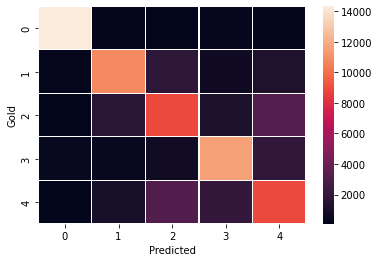

In [26]:
import seaborn as sns

data = np.random.rand(8, 8)
ax = sns.heatmap(confusion_matrix, linewidth=0.3)
ax.set(xlabel='Predicted', ylabel='Gold')
plt.show()